<h1>Sentinel 2 imagery analysis and building indices. Russia. RGB + NIR </h1>

<img src="files\sentinel-2.png" width="300" height="150" align="left"/>

In [1]:
#!pip install earthpy gdal

<h3>Import Modules</h3>

In [2]:
from glob import glob
import os

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.enums import Resampling

import geopandas as gpd

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

#Set treatment for all types of floating-point errors at once:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
os.getcwd()

'D:\\python_projects\\Satellite_Imagery_Analysis'

In [4]:
%cd input/Russia_data

D:\python_projects\Satellite_Imagery_Analysis\input\Russia_data


In [5]:
os.listdir()

['T37UDB_20220414T084601_B01.jp2',
 'T37UDB_20220414T084601_B01.jp2.aux.xml',
 'T37UDB_20220414T084601_B02.jp2',
 'T37UDB_20220414T084601_B02.jp2.aux.xml',
 'T37UDB_20220414T084601_B03.jp2',
 'T37UDB_20220414T084601_B04.jp2',
 'T37UDB_20220414T084601_B05.jp2',
 'T37UDB_20220414T084601_B06.jp2',
 'T37UDB_20220414T084601_B07.jp2',
 'T37UDB_20220414T084601_B08.jp2',
 'T37UDB_20220414T084601_B09.jp2',
 'T37UDB_20220414T084601_B10.jp2',
 'T37UDB_20220414T084601_B11.jp2',
 'T37UDB_20220414T084601_B12.jp2',
 'T37UDB_20220414T084601_B8A.jp2',
 'T37UDB_20220414T084601_TCI.jp2']

<h3>Read original data</h3>

Read only bands with 10 m resolution

In [8]:
sentinel = glob(r"D:\python_projects\Satellite_Imagery_Analysis\input\Russia_data\T37UDB_20220414T084601_B0*[2-4,8]*.jp2")
sentinel.sort()
sentinel

['D:\\python_projects\\Satellite_Imagery_Analysis\\input\\Russia_data\\T37UDB_20220414T084601_B02.jp2',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\Russia_data\\T37UDB_20220414T084601_B03.jp2',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\Russia_data\\T37UDB_20220414T084601_B04.jp2',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\input\\Russia_data\\T37UDB_20220414T084601_B08.jp2']

In [9]:
# Create output directory and the output path
output_dir = os.path.join(r"D:\python_projects\Satellite_Imagery_Analysis", "Russia_outputs")
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)
raster_out_path = os.path.join(output_dir, "raster.tiff")

<h3>Crop data</h3>

In [10]:
# Open the crop boundary using GeoPandas.
crop_bound = gpd.read_file(r"D:\python_projects\Satellite_Imagery_Analysis\input\Russia_shape\Russia_aoi.shp")

# Reproject data
with rio.open(sentinel[0]) as raster_crs:
    crop_raster_profile = raster_crs.profile
    crop_bound = crop_bound.to_crs(crop_raster_profile["crs"])
    
# Crop each band
band_paths_list = es.crop_all(sentinel, output_dir, crop_bound, overwrite=True)    

In [11]:
# Read cropped data
sentinel_crop = glob(r"D:\python_projects\Satellite_Imagery_Analysis\Russia_outputs\*.jp2")
sentinel_crop.sort()
sentinel_crop

['D:\\python_projects\\Satellite_Imagery_Analysis\\Russia_outputs\\T37UDB_20220414T084601_B02_crop.jp2',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\Russia_outputs\\T37UDB_20220414T084601_B03_crop.jp2',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\Russia_outputs\\T37UDB_20220414T084601_B04_crop.jp2',
 'D:\\python_projects\\Satellite_Imagery_Analysis\\Russia_outputs\\T37UDB_20220414T084601_B08_crop.jp2']

<h3> Stack cropped data</h3>

In [12]:
list = []
for i in sentinel_crop:
  with rio.open(i, 'r') as f: list.append(f.read(1))
arr_sent = np.stack(list)
arr_sent.shape

(4, 3955, 2942)

<h3>Data Visualization</h3>

<h4>Visualize Bands</h4>

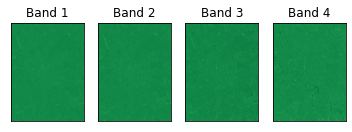

In [21]:
ep.plot_bands(arr_sent,
              cmap='RdYlGn_r',
              cols=4,
              figsize=(5, 3),
              cbar=False)
plt.show()

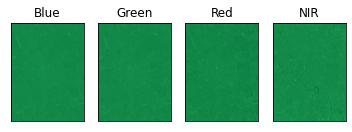

In [22]:
titles = ["Blue", "Green", "Red", "NIR"]

ep.plot_bands(arr_sent,
              cmap='RdYlGn_r',
              cols=4,
              figsize=(5, 3),
              cbar=False,
              title = titles)
plt.show()

<h4>Histograms</h4>

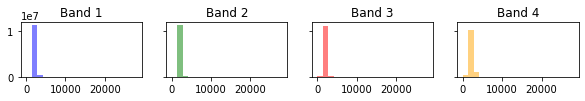

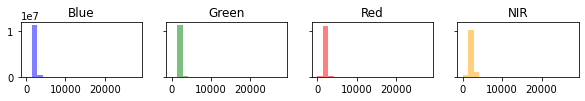

In [26]:
titles = ["Blue", "Green", "Red", "NIR"]
colors = ['Blue', 'Green', 'Red', 'orange']

ep.hist(arr_sent, 
        colors = colors,
        title=[f'Band {i}' for i in range(1, 5)], 
        cols=4, 
        alpha=0.5, 
        figsize = (10, 1)
        )
ep.hist(arr_sent, 
        colors = colors, 
        title = titles,
        cols=4, 
        alpha=0.5, 
        figsize = (10, 1)
        )
plt.show()

<h4>RGB Composite Image</h4>

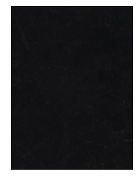

In [25]:
# Bands in a list start from 0, so RGB is no 321, but a 210 combination
ep.plot_rgb(arr_sent,
            rgb=(2, 1, 0),
            figsize=(5, 3))
plt.show()

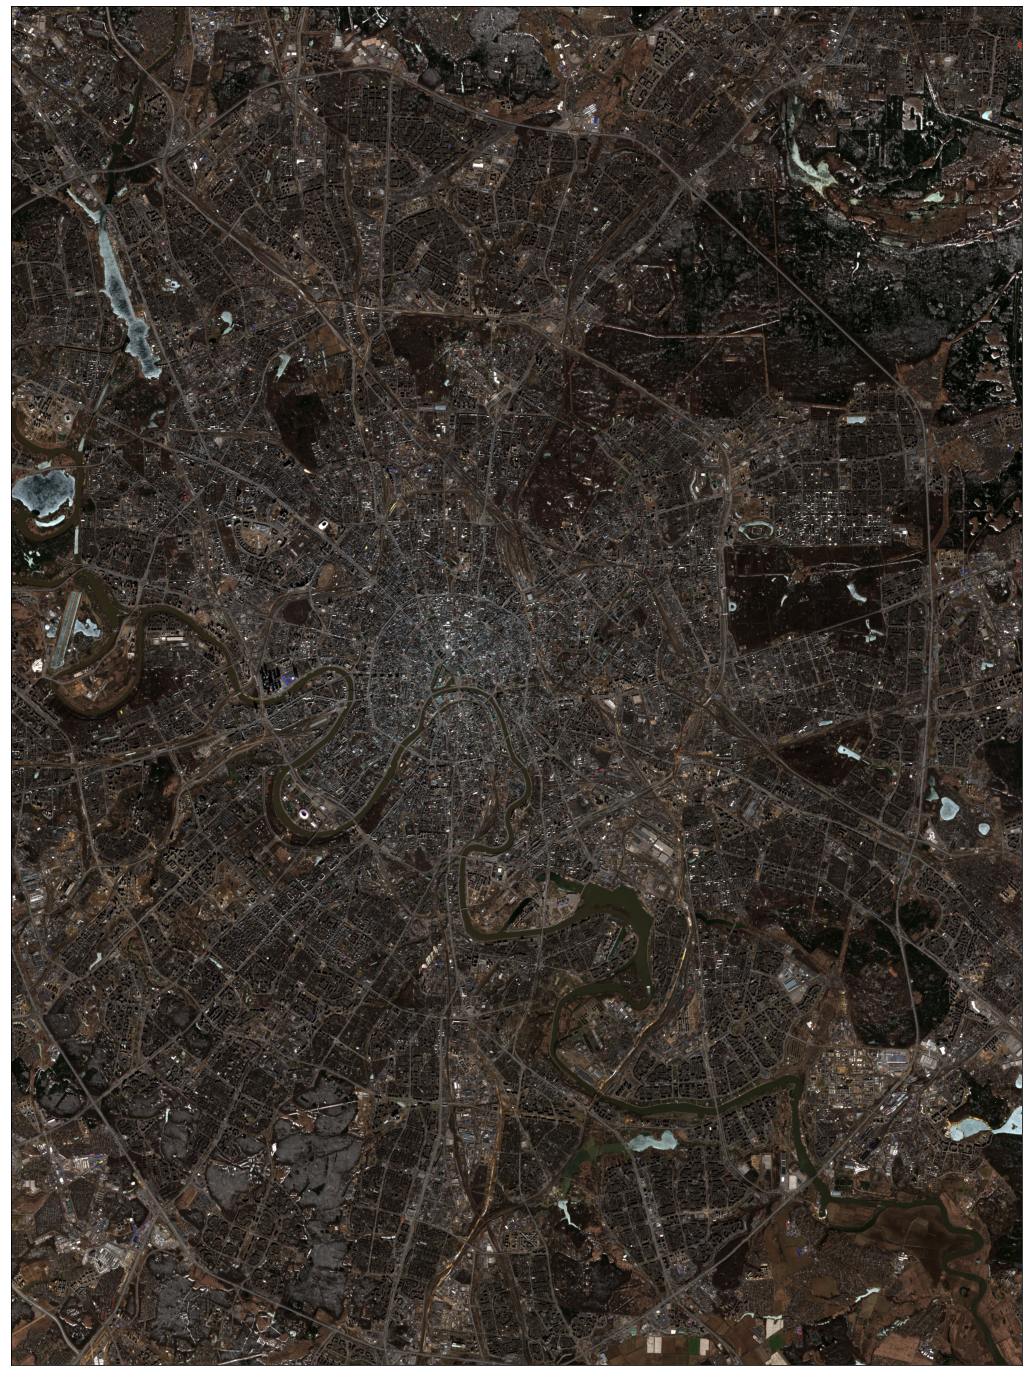

In [28]:
# RGB Composite Image with Stretching Histogram to make pixels brighter
ep.plot_rgb(arr_sent,
            rgb=(2, 1, 0),
            stretch=True,
            str_clip=0.2,
            figsize=(60, 25))
plt.show()

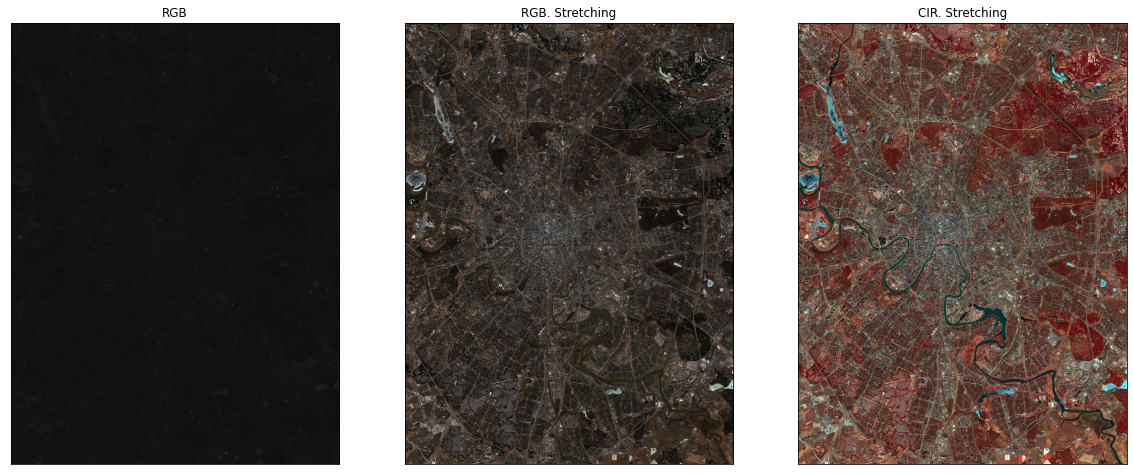

In [35]:
# Create figure with three plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Plot of RGB composite without stretching
ax1=ep.plot_rgb(arr_sent,
            rgb=(2, 1, 0),
            ax=ax1,
            figsize=(10, 5),
            title="RGB")

# Plot of RGB composite with stretching
ax2=ep.plot_rgb(arr_sent,
            rgb=(2, 1, 0),
            ax=ax2,
            stretch=True,
            str_clip=0.2,
            figsize=(10, 5),
            title="RGB. Stretching")

# Plot of CIR composite image with stretching
ax3 = ep.plot_rgb(
    arr_sent,
    rgb=(3, 2, 1),
    ax=ax3,
    stretch=True,
    str_clip=0.5,
    figsize=(10, 5),
    title="CIR. Stretching"
)
plt.show()

<h3>Normalized Difference Vegetation Index (NDVI)</h3>

The normalized difference vegetation index (NDVI) is a simple graphical indicator that can be used to analyze remote sensing measurements, often from a space platform, assessing whether or not the target being observed contains live green vegetation.

NDVI = (NIR – Red) / (NIR + Red)

<h4>Visual interpretation of the output image/raster created:</h4>

<ul>
<li>-1 to 0 - bright surface with no vegetation or water content</li>
<li>+1 - represent water content</li>
</ul>

<img src="files\sentinel-2.png" width="250" height="150" align="left"/>

In [36]:
# NIR is the 4th band, but 4-1=3 in a list, starting from 0
# Red is the 3th band, but 3-1=2 in a list, starting from 0

ndvi = es.normalized_diff(arr_sent[3], arr_sent[2])

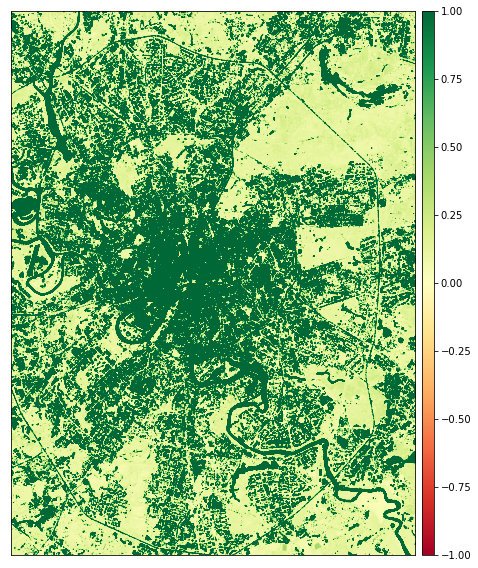

In [37]:
ep.plot_bands(ndvi,
              cmap='RdYlGn',
              vmin=-1,
              vmax=1,
              figsize=(60, 10))
plt.show()